In [15]:
# python libraries
from typing import List,Dict
import time
import sys


sys.path.append("c:\\Users\\Lenovo\\DataspellProjects\\PyTorch2")

# helper module
import helper

# torch
import torch
import torchvision
from torch import nn
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from torchmetrics import Accuracy

# data manipulation
import numpy as np

#visualization
import matplotlib.pyplot as plt

%matplotlib widget

# FashionMNIST

## Loading the dataset

In [16]:
class FashionMNIST(helper.DataModule):
    def __init__(self, batch_size=64, resize=(28, 28)) -> None:
        super().__init__()
        self.batch_size = batch_size
        self.resize = resize

        transform = transforms.Compose(
            [transforms.Resize(resize), transforms.ToTensor()]
        )

        self.train = datasets.FashionMNIST(
            root=self.root, train=True, transform=transform, download=True
        )
        self.val = datasets.FashionMNIST(
            root=self.root, train=False, transform=transform, download=True
        )
        self.classes = self.train.classes
        self.class_to_idx = self.train.class_to_idx

    def text_labels(self, indices: List):
        return [self.classes[int(i)] for i in indices]

    def get_dataloader(self, train: bool):
        data = self.train if train else self.val
        return DataLoader(
            dataset=data,
            batch_size=self.batch_size,
            shuffle=train,
            num_workers=self.num_workers,
        )

    def visualize(self, batch, num_rows=1, num_cols=8):
        X, y = batch
        labels = self.text_labels(y)
        helper.show_images(
            X.squeeze(dim=1), num_rows=num_rows, num_cols=num_cols, titles=labels
        )


In [17]:
data  = FashionMNIST(resize=(32,32))

In [18]:
# start = time.time()
# for X,y in data.train_dataloader():
#     continue
# f"{time.time() - start:.2f} secs"

#? Built in data loader itself take long time to load.

In [19]:
X,y = next(iter(data.train_dataloader()))
X.shape,X[0].shape, y.shape

(torch.Size([64, 1, 32, 32]), torch.Size([1, 32, 32]), torch.Size([64]))

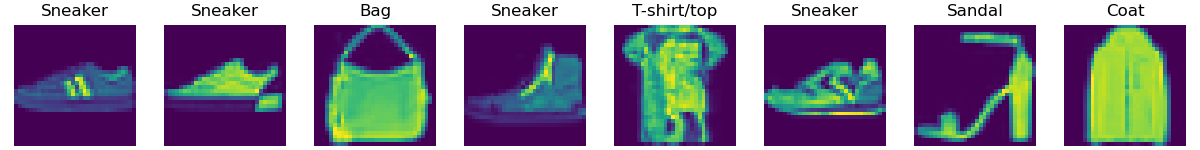

In [20]:
batch = next(iter(data.train_dataloader()))
data.visualize(batch=batch)


# Base Classifier

In [21]:
class Classifier(helper.Module):
    def accuracy(self,y_logits, y):
        acc_fn = Accuracy(task="multiclass",num_classes=self.num_outputs)
        return acc_fn(y_logits, y)

    def step(self, batch: List)->Dict:
        X, y = batch
        # forward pass
        y_logits = self(X).squeeze(1)
        loss = self.loss(y_logits, y)
        acc = self.accuracy(y_logits, y)
        return dict(loss=loss,acc=acc)

    def validation_step(self, batch: List):
        return self.step(batch)

    def training_step(self, batch: List):
        return self.step(batch)

    def loss(self, y_logits, y):
        loss_fn = nn.CrossEntropyLoss()
        return loss_fn(y_logits, y)


# Classifier

In [22]:
class SoftmaxRegression(Classifier):
    def __init__(self,num_outputs,lr) -> None:
        super().__init__()
        self.num_outputs = num_outputs
        self.lr = lr
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(self.num_outputs)
        )
    
    def forward(self,x):
        return self.net(x)



# Training process

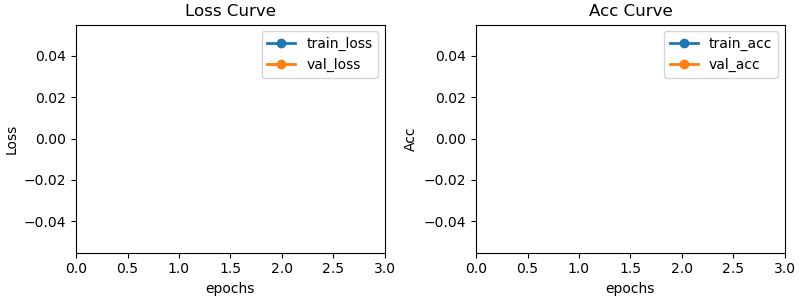

In [28]:
data = FashionMNIST(batch_size=256)
model = SoftmaxRegression(num_outputs=10,lr=0.1)
trainer = helper.Trainer(max_epochs=3,show_ani=True)
trainer.fit(model,data)

In [25]:
trainer.ani_plot.line_dict

[INFO] ylim set


defaultdict(matplotlib.lines.Line2D,
            {'train_loss': <matplotlib.lines.Line2D at 0x1c2302c4c10>,
             'val_loss': <matplotlib.lines.Line2D at 0x1c2302c4f10>,
             'train_acc': <matplotlib.lines.Line2D at 0x1c2302ec850>,
             'val_acc': <matplotlib.lines.Line2D at 0x1c2306fd580>})

In [ ]:
(trainer.ani_plot.axes[0]).get_children()

In [ ]:
(trainer.ani_plot.axes[0]).get_children()[0].get_data()

In [ ]:
trainer.history

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def data_gen():
    t = data_gen.t
    cnt = 0
    while cnt < 1000:
        cnt+=1
        t += 0.05
        y1 = np.sin(2*np.pi*t) * np.exp(-t/10.)
        y2 = np.cos(2*np.pi*t) * np.exp(-t/10.)
        # adapted the data generator to yield both sin and cos
        yield t, y1, y2

data_gen.t = 0

# create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2,1)

# intialize two line objects (one in each axes)
line1, = ax1.plot([], [], lw=2)
line2, = ax2.plot([], [], lw=2, color='r')
line = [line1, line2]

# the same axes initalizations as before (just now we do it for both of them)
for ax in [ax1, ax2]:
    ax.set_ylim(-1.1, 1.1)
    ax.set_xlim(0, 5)
    ax.grid()

# initialize the data arrays 
xdata, y1data, y2data = [], [], []
def run(data):
    # update the data
    t, y1, y2 = data
    xdata.append(t)
    y1data.append(y1)
    y2data.append(y2)

    # axis limits checking. Same as before, just for both axes
    for ax in [ax1, ax2]:
        xmin, xmax = ax.get_xlim()
        if t >= xmax:
            ax.set_xlim(xmin, 2*xmax)
            ax.figure.canvas.draw()

    # update the data of both line objects
    line[0].set_data(xdata, y1data)
    line[1].set_data(xdata, y2data)

    return line

ani = animation.FuncAnimation(fig, run, data_gen, blit=True, interval=10,
    repeat=False)
plt.show()

In [11]:
(trainer.ani_plot.axes[0]).get_children()

 Text(0.5, 1.0, 'Loss Curve'),
 Text(0.0, 1.0, ''),
 Text(1.0, 1.0, ''),

In [12]:
(trainer.ani_plot.axes[0]).get_children()[0].get_data()

([0, 1, 2], [0.7881826162338257, 0.5714845657348633, 0.5256046652793884])

In [13]:
trainer.history

defaultdict(list,
            {'train_loss': [0.7881826162338257,
              0.5714845657348633,
              0.5256046652793884],
             'train_acc': [0.7479221820831299,
              0.8121953010559082,
              0.8256427645683289],
             'val_loss': [0.6433461308479309,
              0.5671110153198242,
              0.5442603230476379],
             'val_acc': [0.773242175579071,
              0.80712890625,
              0.8124023675918579]})

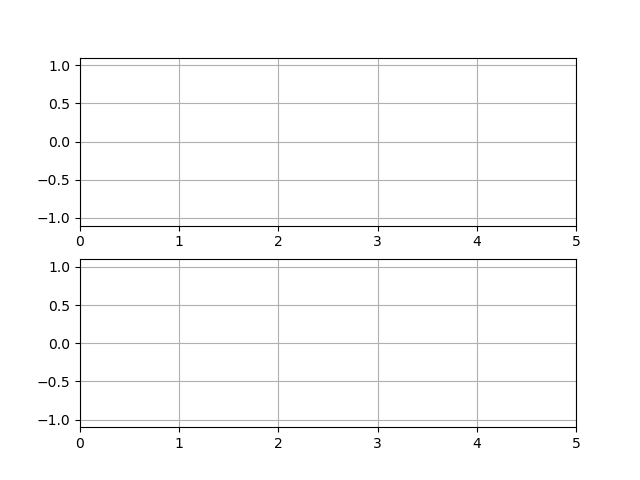

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def data_gen():
    t = data_gen.t
    cnt = 0
    while cnt < 1000:
        cnt+=1
        t += 0.05
        y1 = np.sin(2*np.pi*t) * np.exp(-t/10.)
        y2 = np.cos(2*np.pi*t) * np.exp(-t/10.)
        # adapted the data generator to yield both sin and cos
        yield t, y1, y2

data_gen.t = 0

# create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2,1)

# intialize two line objects (one in each axes)
line1, = ax1.plot([], [], lw=2)
line2, = ax2.plot([], [], lw=2, color='r')
line = [line1, line2]

# the same axes initalizations as before (just now we do it for both of them)
for ax in [ax1, ax2]:
    ax.set_ylim(-1.1, 1.1)
    ax.set_xlim(0, 5)
    ax.grid()

# initialize the data arrays 
xdata, y1data, y2data = [], [], []
def run(data):
    # update the data
    t, y1, y2 = data
    xdata.append(t)
    y1data.append(y1)
    y2data.append(y2)

    # axis limits checking. Same as before, just for both axes
    for ax in [ax1, ax2]:
        xmin, xmax = ax.get_xlim()
        if t >= xmax:
            ax.set_xlim(xmin, 2*xmax)
            ax.figure.canvas.draw()

    # update the data of both line objects
    line[0].set_data(xdata, y1data)
    line[1].set_data(xdata, y2data)

    return line

ani = animation.FuncAnimation(fig, run, data_gen, blit=True, interval=10,
    repeat=False)
plt.show()